In [6]:
from google.colab import files
uploaded = files.upload()

Saving data.csv to data (1).csv


In [7]:
import pandas as pd
import numpy as np

df = pd.read_csv('data.csv')
print(f"original data: {len(df)}")
print("original row:", df.columns.tolist())

#data cleaning

# Delete the records with missing key fields
df = df.dropna(subset=['price', 'sqft_living', 'bedrooms', 'bathrooms', 'yr_built', 'date'])

df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['city_code'] = df['city'].astype('category').cat.codes
df['statezip'] = df['statezip'].astype('category').cat.codes

# delete unreasonal data
df = df[df['bedrooms'] > 0]
df = df[df['bathrooms'] > 0]
df = df[(df['sqft_living'] > 100) & (df['sqft_lot'] > 100)]
df = df[(df['floors'] > 0) & (df['floors'] <= 4)]
df = df[df['yr_built'] >= 1900]
df = df[df['price'] > 0]

# IQR
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[col] >= lower) & (df[col] <= upper)]

df = remove_outliers(df, 'price')
df = remove_outliers(df, 'sqft_living')
df = remove_outliers(df, 'sqft_lot')

print("\ndata after cleaning:", len(df))

original data: 4600
original row: ['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'street', 'city', 'statezip', 'country']

data after cleaning: 3757


In [8]:
from sklearn.model_selection import train_test_split

# Select features and target
features = [
    'bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront',
    'view','condition','sqft_above','sqft_basement','yr_built','yr_renovated',
    'year','month','city_code','statezip'
]
target = 'price'

# Prepare feature matrix (X) and target vector (y)
X = df[features]
y = df[target]

# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#log-transform the target
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)


In [9]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Train Gradient Boosted Tree model
gbt = GradientBoostingRegressor(
    n_estimators=300,   # number of boosting stages
    learning_rate=0.05,  # step size shrinkage
    max_depth=5,# depth of individual trees
    random_state=42
)
gbt.fit(X_train, y_train_log)

# Predict and evaluate
y_pred_log = gbt.predict(X_test)
y_pred = np.expm1(y_pred_log)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"Gradient Boosted Tree Performance:")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


Gradient Boosted Tree Performance:
R²: 0.7742
MAE: 69539.52
RMSE: 98252.25
MAPE: 15.95%


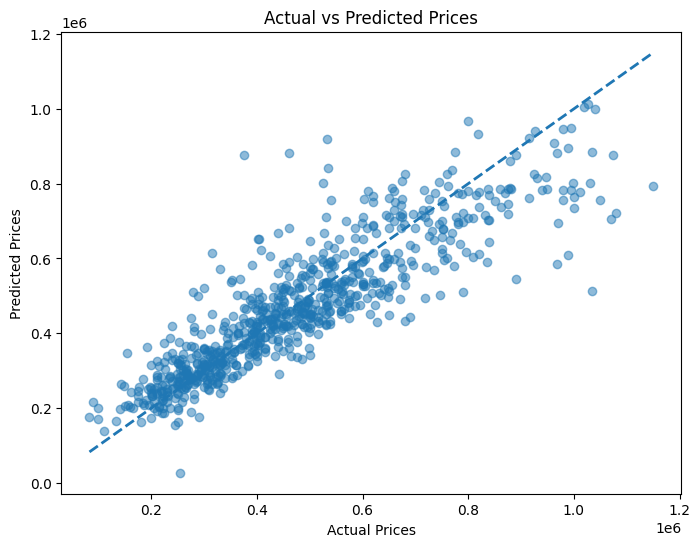

In [10]:
import matplotlib.pyplot as plt
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', linewidth=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.show()


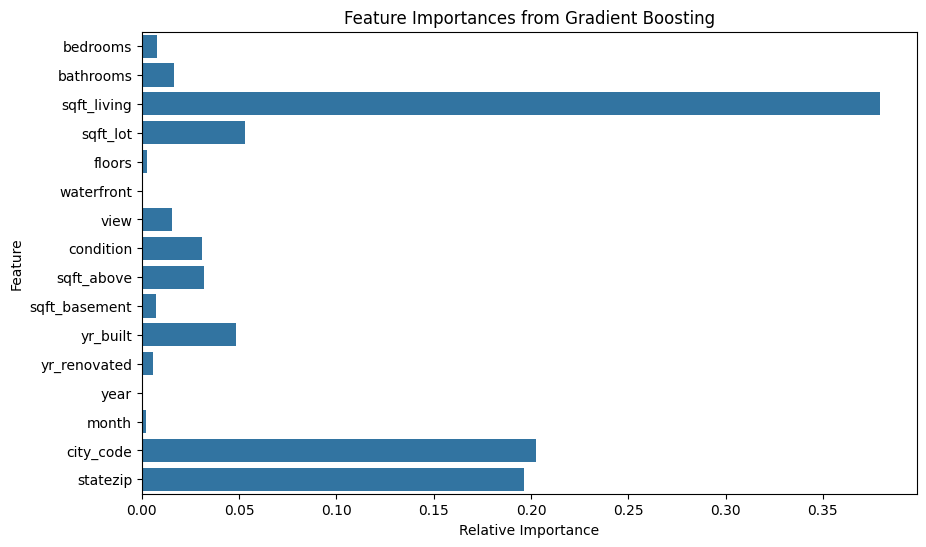

In [11]:
# Plot feature importances
import seaborn as sns

feature_importances = pd.Series(gbt.feature_importances_, index=features)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Feature Importances from Gradient Boosting')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.show()
